In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from functools import partial
from natsort import natsorted

import problems as pbs
import solvers as svs
from utils import *

from torch.utils.data import DataLoader
from train_dpt import DPTSolver, custom_collate_fn, OnlineDataset, OfflineDataset
import lightning as L

Get a model from a checkpoint.

In [3]:
def get_checkpoint(run_name):
    root_dir = os.path.join("results", "DPT_3", run_name, "checkpoints")
    checkpoint = natsorted(os.listdir(root_dir))[-1]
    checkpoint_file = os.path.join(root_dir, checkpoint)
    return checkpoint_file

device = "cuda:0"

In [4]:
model_d10 = "cv3zhugo"
model_d25 = "dx72pu5v"
model_d50 = "n56kuud3"
model_ad_d50 = "ubpuvnmm"
checkpoint_file = get_checkpoint(model_ad_d50)
model = DPTSolver.load_from_checkpoint(checkpoint_file)
model = model.to(device)
checkpoint_file

'results/DPT_3/ubpuvnmm/checkpoints/last.ckpt'

Get test problems.

In [5]:
problem_path_normal = "data/d_50__dist_normal__n_2__n_probes_0__n_problems_256000__problem_QUBO__solver_None__test.dill"
problem_path_unif = "data/d_50__n_2__n_probes_0__n_problems_31000__problem_QUBO__solver_None__test.dill"
problems = pbs.deserialize_problem_set(problem_path_normal).problems

In [6]:
problem_config = model.config['problem_params']
problem_config['dist'] = 'unif'
problem_config['solver'] = None

In [7]:
problem_class = pbs.QUBO

In [8]:
new_problems = [problem_class(**problem_config) for _ in range(len(problems))]

In [9]:
import torch

In [10]:
for i in range(len(problems)):
    new_problems[i].Q = torch.tensor(problems[i].Q, dtype=torch.float)

Define a budget.

In [11]:
import collections

In [12]:
budget = 2 * model.config["model_params"]["seq_len"]

Set a tester.

In [13]:
tester = L.Trainer(logger=False, precision=model.config["precision"])

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
import problems as pbs

In [15]:
dataset = OnlineDataset(new_problems)
collate_fn = partial(custom_collate_fn, problem_class=pbs.QUBO)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=1000,
    num_workers=1,
    pin_memory=True,
    shuffle=False,
    collate_fn=collate_fn
)

In [16]:
problem_class = getattr(pbs, 'QUBO')
problem_class, type(dataset[0]['problem']), type(dataset[0]['problem']) == problem_class

(problems.qubo.QUBO, problems.qubo.QUBO, True)

In [17]:
logs = {}

In [18]:
model_type = "AD"

In [19]:
warmup = 0

model.config["online_steps"] = int(budget - warmup)
model.config["do_sample"] = False
model.config["model_params"]["warmup"] = warmup
with torch.inference_mode():
    tester.test(model=model, dataloaders=dataloader)
logs |= {
    f"{model_type} (argmax)": {
        "m_list": np.arange(budget) + 1,
        "y_list (mean)": model.trajectory.cpu().numpy()
    }
}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jovyan/.mlspace/envs/kurkin_exps/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [20]:
warmup = 0
model.config["online_steps"] = int(budget - warmup)
model.config["model_params"]["warmup"] = warmup
model.config["do_sample"] = True

with torch.inference_mode():
    tester.test(model=model, dataloaders=dataloader)
logs |= {
    f"{model_type} (sampling)": {
        "m_list": np.arange(budget) + 1,
        "y_list (mean)": model.trajectory.cpu().numpy()
    }
}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [21]:
warmup = 50

model.config["online_steps"] = int(budget - warmup)
model.config["do_sample"] = False
model.config["model_params"]["warmup"] = warmup
with torch.inference_mode():
    tester.test(model=model, dataloaders=dataloader)
logs |= {
    f"{model_type} (argmax warmup)": {
        "m_list": np.arange(budget) + 1,
        "y_list (mean)": model.trajectory.cpu().numpy()
    }
}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [22]:
warmup = 50

model.config["online_steps"] = int(budget - warmup)
model.config["do_sample"] = True
model.config["model_params"]["warmup"] = warmup

with torch.inference_mode():
    tester.test(model=model, dataloaders=dataloader)
logs |= {
    f"{model_type} (sampling warmup)": {
        "m_list": np.arange(budget) + 1,
        "y_list (mean)": model.trajectory.cpu().numpy()
    }
}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
# logs_path = "d_10_trained_normal_dpt.json"

# with open(logs_path, 'r') as f:
#     logs = json.load(f)

In [30]:
import math

In [31]:
warmup = 0

model.config["online_steps"] = int(budget - warmup)
model.config["do_sample"] = True
model.config["model_params"]["warmup"] = warmup
model.config["temperature"] = lambda x: math.sqrt(x)


with torch.inference_mode():
    tester.test(model=model, dataloaders=dataloader)
logs |= {
    f"{model_type} (sqrt sampling)": {
        "m_list": np.arange(budget) + 1,
        "y_list (mean)": model.trajectory.cpu().numpy()
    }
}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [23]:
warmup = 0

import math

model.config["online_steps"] = int(budget - warmup)
model.config["do_sample"] = True
model.config["model_params"]["warmup"] = warmup
model.config["temperature"] = lambda x: 5 - 4 * x
tester.test(model=model, dataloaders=dataloader)
logs |= {
    f"{model_type} (5->1 sampling)": {
        "m_list": np.arange(budget) + 1,
        "y_list (mean)": model.trajectory.cpu().numpy()
    }
}

/home/jovyan/.mlspace/envs/kurkin_exps/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'config' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['config'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [24]:
traj = torch.cat(model.trajectories).to("cpu")

In [25]:
traj.shape

torch.Size([1000, 400])

In [26]:
traj[:, :-1].unsqueeze(-1).shape

torch.Size([1000, 399, 1])

In [27]:
rewards = model.reward_model.offline(traj[:, :-1].unsqueeze(-1), None, traj[:, 1:].unsqueeze(-1))

In [28]:
rewards

tensor([[3.8954, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 3.7177, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1861,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.6880, 0.6035, 0.0000,  ..., 0.0424, 0.0000, 0.0000],
        [4.0443, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [29]:
rtg = rewards.cumsum(1)

In [30]:
rtg.shape

torch.Size([1000, 399])

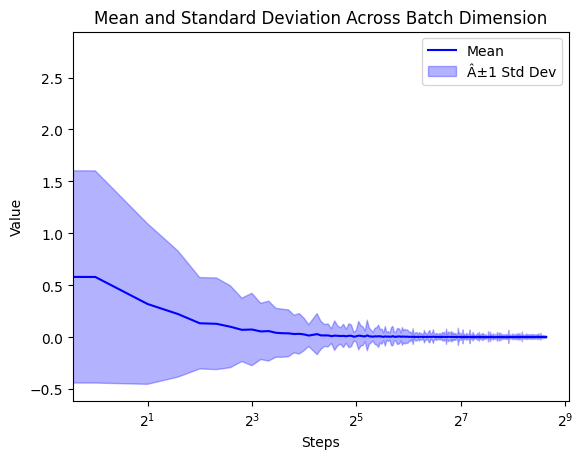

In [31]:
mean = np.mean(rewards.numpy(), axis=0)
std = np.std(rewards.numpy(), axis=0)

# Create x-axis values (steps)
steps = np.arange(rewards.size(1))

# Plot the mean
plt.plot(steps, mean, label='Mean', color='blue')

# Shade the region between mean Â± std
plt.fill_between(steps, mean - std, mean + std, color='blue', alpha=0.3, label='Â±1 Std Dev')

# Add labels and legend
plt.xlabel('Steps')
plt.ylabel('Value')
plt.xscale("log", base=2)
plt.title('Mean and Standard Deviation Across Batch Dimension')
plt.legend()

# Show the plot
plt.show()

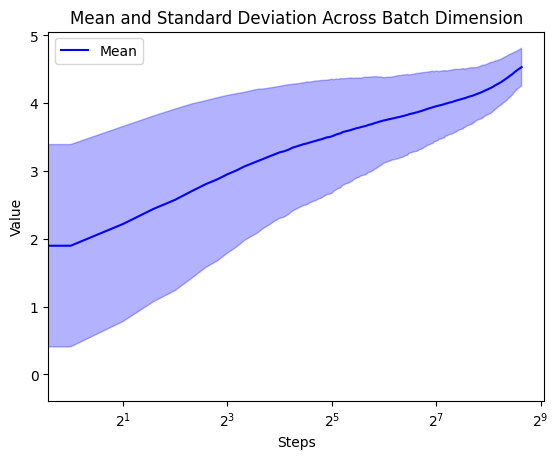

In [33]:
mean = np.mean(rtg.numpy(), axis=0)
std = np.std(rtg.numpy(), axis=0)

# Create x-axis values (steps)
steps = np.arange(rewards.size(1))

# Plot the mean
plt.plot(steps, mean, label='Mean', color='blue')

# Shade the region between mean Â± std
plt.fill_between(steps, mean - std, mean + std, color='blue', alpha=0.3)

# Add labels and legend
plt.xlabel('Steps')
plt.ylabel('Value')
plt.xscale("log", base=2)
plt.title('Mean and Standard Deviation Across Batch Dimension')
plt.legend()

# Show the plot
plt.show()

In [32]:
warmup = 0

import math

model.config["online_steps"] = int(budget - warmup)
model.config["do_sample"] = True
model.config["model_params"]["warmup"] = warmup
model.config["temperature"] = lambda x: 1 / math.sqrt(1 + x)
tester.test(model=model, dataloaders=dataloader)
logs |= {
    f"{model_type} (rsqrt sampling)": {
        "m_list": np.arange(budget) + 1,
        "y_list (mean)": model.trajectory.cpu().numpy()
    }
}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [34]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

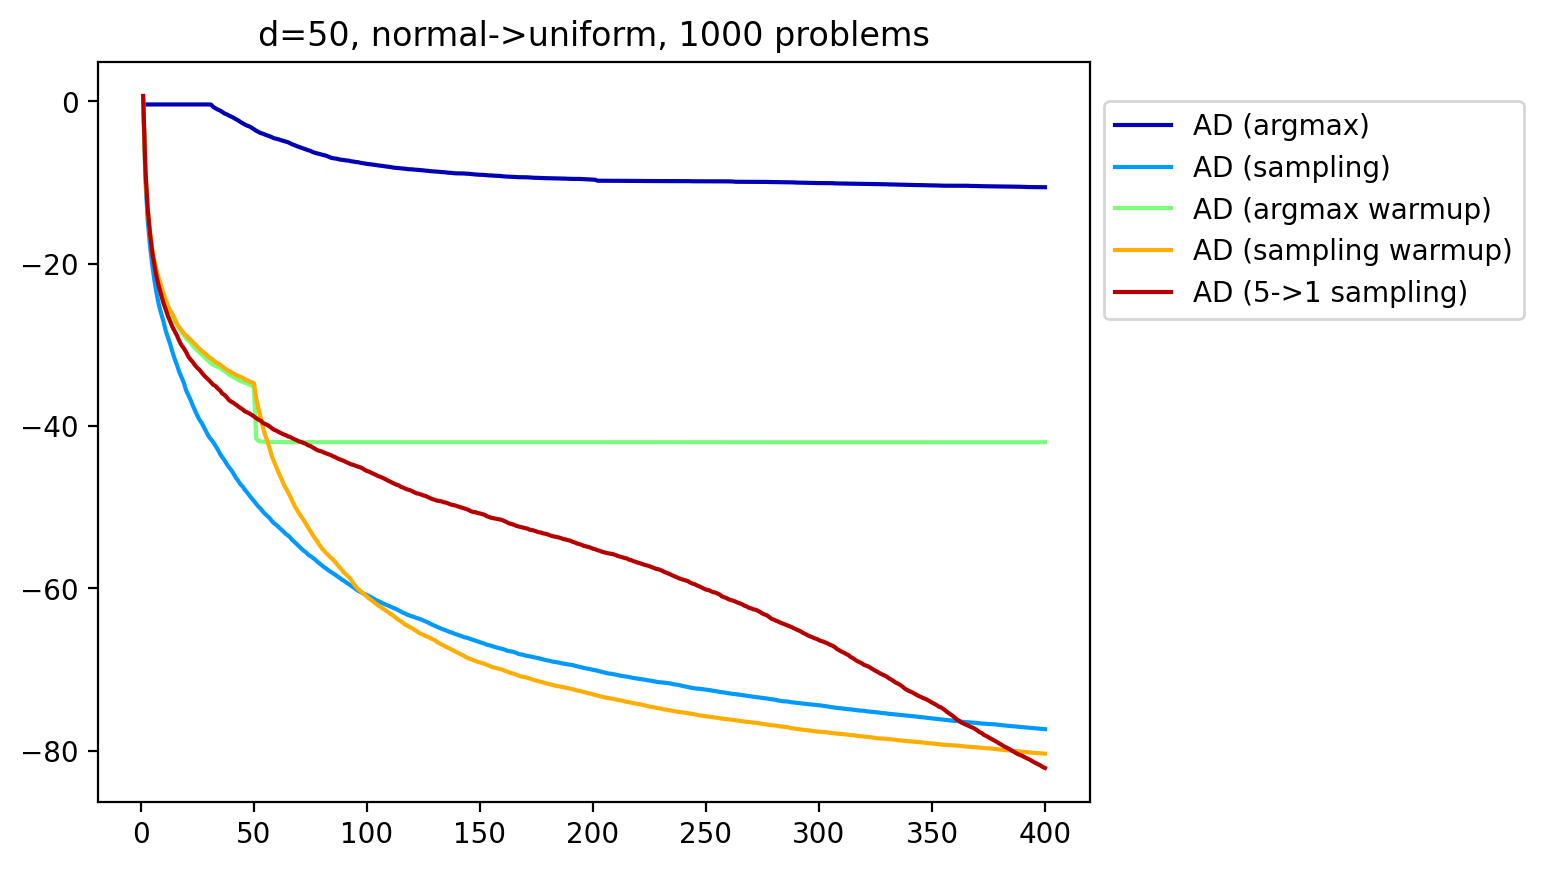

In [35]:
plot_logs(logs, problems, title="d=50, normal->uniform")

In [36]:
from tqdm.auto import tqdm

In [40]:
for problem  in tqdm(problems[:250]):
    problem.solver = "gurobi"
    problem.n_probes = 1
    problem.device = "cpu"
    problem.find_target()

  0%|          | 0/250 [00:00<?, ?it/s]

In [41]:
y_min = [problem.info['y_min'] for problem in problems if problem.info['y_min'] is not None]

In [42]:
np.mean(y_min)

-104.22774

In [29]:
config = model.config
config["batch_size"] = 512
config["problem_params"]["use_problems"] = 31000
config["problem_params"]["n_problems"] = 31000
config["problem_params"]["n_probes"] = 10
config["problem_params"]["solver"] = "gurobi"

In [32]:
from run import ProblemDataModule

In [ ]:
for d in [50, 25, 10]:
    config["problem_params"]["d"] = d
    datamodule = ProblemDataModule(config)
    datamodule.prepare_data()

Generating dataset...


  0%|          | 0/31000 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2026-11-23


In [43]:
for solver_name, solver_info in logs.items():
    logs[solver_name] = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in solver_info.items()}

In [44]:
logs_path = "d_50_randn_ad.json"

with open(logs_path, 'w') as f:
    json.dump(logs, f, indent=4)

Other solvers

In [15]:
solvers = [
    ("PROTES", partial(svs.PROTES, budget=budget, k_samples=20, k_top=5)),
    ("OnePlusOne", partial(svs.OnePlusOne, budget=budget)),
    ("PSO", partial(svs.PSO, budget=budget)),
    ("Portfolio", partial(svs.Portfolio, budget=budget)),
    ("RandomSearch", partial(svs.RandomSearch, budget=budget))
]

In [18]:
save_dir = "results/testing/QUBO_n_2_d_10"
# run(save_dir, problems, solvers, n_runs=10)

In [ ]:
logs |= read_problemset(save_dir, problems)

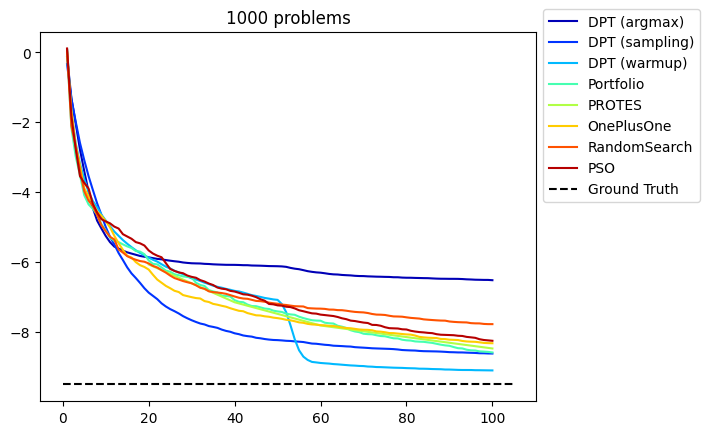

In [20]:
plot_logs(logs, problems)